Honeynet Challenge from 2010: Banking Troubles 
===

Worked for practice long after the contest by @adricnet with dozens of Remnux tools, especially the Volatility memory analysis framework. *Any original material Copyleft 2015 CC-BY-SA adric.net*

Scenario
------

Source http://www.honeynet.org/challenges/2010_3_banking_troubles

Evidence:
-----

**Primary Source**: Bob.vmem, a WinXp memory image
1b9bd5c614cb3726cd048eb5f094e81389e56c888424b8b7affb41694e7caad8  Bob.vmem, provided, 

Volatility profile selected: --profile=WinXPSP3x86

```
          Suggested Profile(s) : WinXPSP2x86, WinXPSP3x86
                     AS Layer1 : IA32PagedMemoryPae (Kernel AS)
                     AS Layer2 : FileAddressSpace (/home/remnux/hnfc/Bob.vmem)
                      PAE type : PAE
                           DTB : 0x319000L
                          KDBG : 0x80544ce0
          Number of Processors : 1
     Image Type (Service Pack) : 2
                KPCR for CPU 0 : 0xffdff000
             KUSER_SHARED_DATA : 0xffdf0000
           Image date and time : 2010-02-27 20:12:38 UTC+0000
     Image local date and time : 2010-02-27 15:12:38 -0500
```


Processes and relationships
-----------------------------

This the process tree from volatility *pstree*, trimmed to the processes we later found to be of interest in the investigation FireFox, Acrobat Reader, and their parent Explorer.

```
volatility -f Bob.vmem --profile=WinXPSP3x86 pstree > bob-pstree.txt

Name                                                  Pid   PPid   Thds   Hnds Time
-------------------------------------------------- ------ ------ ------ ------ ----
 0x81cdd790:explorer.exe                             1756   1660     14    345 2010-02-26 03:34:38 UTC+0000
. 0x820cd5c8:VMwareUser.exe                          1116   1756      4    179 2010-02-26 03:34:39 UTC+0000
. 0x81ca96f0:VMwareTray.exe                          1108   1756      1     59 2010-02-26 03:34:39 UTC+0000
. 0x82068020:firefox.exe                              888   1756      9    172 2010-02-27 20:11:53 UTC+0000
.. 0x820618c8:AcroRd32.exe                           1752    888      8    184 2010-02-27 20:12:23 UTC+0000
 0x823c8830:System                                      4      0     58    573 1970-01-01 
```

Network connections
----------------------

This is the complete output of volatility *connections* plugin. We have to use connections on WinXP.

```
$ volatility -f Bob.vmem --profile=WinXPSP3x86 connections > bob-connections.txt

Offset(V)  Local Address             Remote Address            Pid
---------- ------------------------- ------------------------- ---
0x81c6a9f0 192.168.0.176:1176        212.150.164.203:80        888
0x82123008 192.168.0.176:1184        193.104.22.71:80          880
0x81cd4270 192.168.0.176:2869        192.168.0.1:30379         1244
0x81e41108 127.0.0.1:1168            127.0.0.1:1169            888
0x8206ac58 127.0.0.1:1169            127.0.0.1:1168            888
0x82108890 192.168.0.176:1178        212.150.164.203:80        1752
0x82210440 192.168.0.176:1185        193.104.22.71:80          880
0x8207ac58 192.168.0.176:1171        66.249.90.104:80          888
0x81cef808 192.168.0.176:2869        192.168.0.1:30380         4
0x81cc57c0 192.168.0.176:1189        192.168.0.1:9393          1244
0x8205a448 192.168.0.176:1172        66.249.91.104:80          888

```

Initial leads
------

Our first lead id the Firefox -> Acrobat Reader process parent/child connection. 
The Acroread process has an outbound internet connection. Even coming to the case blind this is a suspicious pattern,as legitimate access of PDFs to Internet resources is an uncommon scenario in most organizations.

Additional context from the Volatility generated screenshot shows PDF.php open in FireFox at time of memory image. We trivially resize the image in Jupyter notebook, though a crop and red circle on the top left tab header would be nicer here.

```$ volatility -f Bob.vmem --profile=WinXPSP3x86 screenshot -D .```

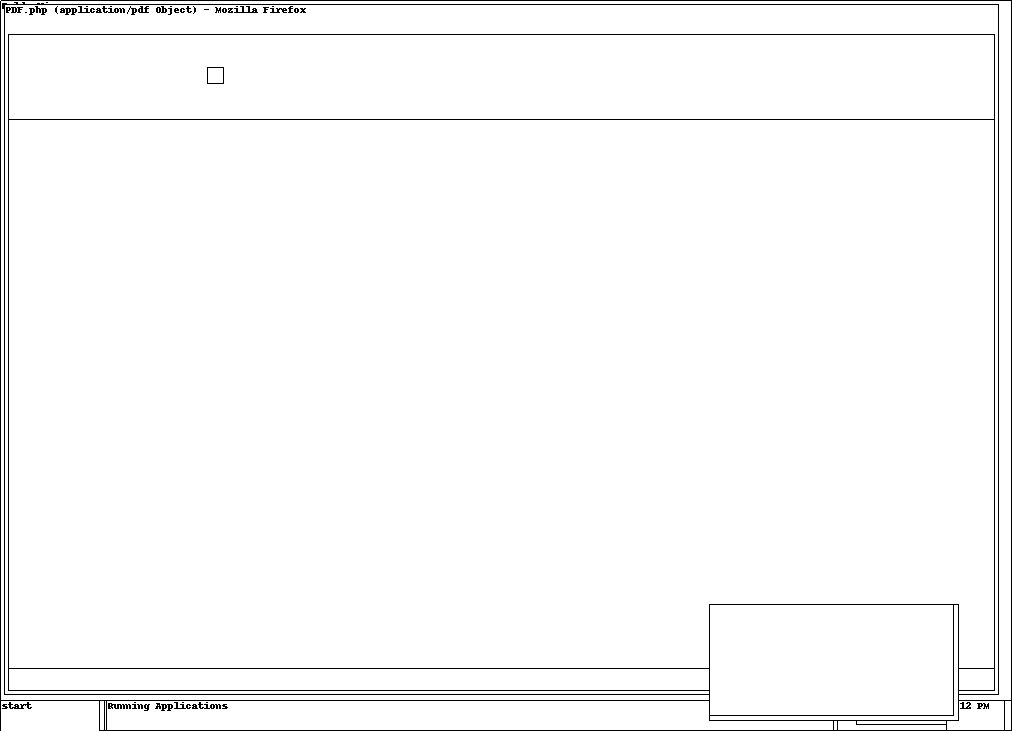

In [3]:
from IPython.display import Image
image = Image(filename='session_0.WinSta0.Default.png', width=600)
image

Times
----
From *imageinfo*:

Image time (UTC) is 2010-02-27 20:12:38 UTC+0000.8:12PM. This is only a few seconds after AcroRead was launched. This is plausible for a challenge data set.

From *pstree*:

* System boot time may be near 03:34 (3am) the previous day, according to explorer and winlogin start times.
* Firefox process executed at 2010-02-27 20:11:53 UTC+0000 , 8:11PM
* Acrobat Reader process 2010-02-27 20:12:23, 8:11:PM


Then
-----

I looked at the strings, dumped PE images, command lines, library usage and process meta of the FireFox, acroread, svchost and msiexec processes with volatility plugins *dllist*, *procdump*, *malfind*, and *malsysproc* 

Although malfind noted some suspicious RWX pages in a couple places it didn't seem a solid lead to me.

```
$ head -3 *-mf.txt 
==> bob-1752-mf.txt <==
Process: AcroRd32.exe Pid: 1752 Address: 0x30000
Vad Tag: VadS Protection: PAGE_EXECUTE_READWRITE
Flags: CommitCharge: 29, MemCommit: 1, PrivateMemory: 1, Protection: 6

==> bob-244-mf.txt <==
Process: msiexec.exe Pid: 244 Address: 0x890000
Vad Tag: VadS Protection: PAGE_EXECUTE_READWRITE
Flags: CommitCharge: 29, MemCommit: 1, PrivateMemory: 1, Protection: 6

==> bob-888-mf.txt <==
Process: firefox.exe Pid: 888 Address: 0x1e80000
Vad Tag: VadS Protection: PAGE_EXECUTE_READWRITE
Flags: CommitCharge: 29, MemCommit: 1, PrivateMemory: 1, Protection: 6
```

Malsysproc flagged one of the service hosts processes.

```
volatility -f Bob.vmem --profile=WinXPSP3x86 malsysproc > bob-malsysproc.txt

Offset     ProcessName  PID   Name  Path  PPId  Time  Priority  Cmdline Count
---------- ------------ ----- ----- ----- ----- ----- --------- ------- -----
0x81f04228 smss.exe       548 True  True  True  True  True      True    True 
0x822eeda0 csrss.exe      612 True  True  True  True  True      True    True 
0x81e5b2e8 winlogon.exe   644 True  True  True  True  True      True    True 
0x82256da0 services.exe   688 True  True  True  True  True      True    True 
0x82129da0 lsass.exe      700 True  True  True  True  True      True    True 
0x82266870 svchost.exe    880 True  True  True  True  True      True    True 
0x822e1da0 svchost.exe    948 True  True  True  True  True      True    True 
0x822ea020 svchost.exe   1040 True  True  True  True  True      True    True 
0x81dea020 svchost.exe   1100 True  True  True  True  True      True    True 
0x81de55f0 svchost.exe   1244 True  True  True  True  True      True    True 
0x81dde568 spoolsv.exe   1460 True  True  True  True  True      True    True 
0x82209640 svchost.exe   1384 True  True  True  False True      True    True 
```

Of the two msiexec process in chain, only one was available to dump in the image (the other may have been paged out). I compared the strings and PE meta (from *mastiff*) of the msiexec (3.3.x) to the one avaiable from a Win10 baseline system and they lined up pretty well

Based on the initial suspicion about FireFox and Acroread I decided to look for the PDF.php file. In the normal functioning of internet browser and helper programs the file would have been downloaded, possibly to a temporary folder, and then the utility program (acroread) would be invoked to open the downloaded file.

PDF.php
-----------

I recovered the suspect PDF file (likely thrown by php script) from file handles of Acroread with Volatility *handles*, *filescan*, *dumpfiles* pretty much straight from the (old) online manual pages: 

* https://code.google.com/p/volatility/wiki/CommandReference23#filescananual.
* https://code.google.com/p/volatility/wiki/CommandReference23#dumpfiles

Filescan and handles show us that the file was mapped and where it was on disk. We can pull all of the handles and then filter to the process id of ArcoRead (1752) after with grep. Dumpfiles can be filtered by regex or PID.

```
$ volatility -f Bob.vmem --profile=WinXPSP3x86 handles > bob-handles.txt

$ grep 1752 bob-handles.txt > bob-acro-handles.txt

$ head -2 bob-handles.txt; grep php bob-acro-handles.txt #borrow the header

Offset(V)     Pid     Handle     Access Type                       Details
---------- ------ ---------- ---------- -------------------------- -------
0x81dfadf0   1752      0x1d4   0x120089 File                       \Device\HarddiskVolume1\DOCUME~1\ADMINI~1\LOCALS~1\Temp\plugtmp\PDF.php
```

```
$ volatility -f Bob.vmem --profile=WinXPSP3x86 filescan > bob-filescan.txt

$ grep php bob-filescan.txt

0x0000000001ffadf0      3      1 R--r-- \Device\HarddiskVolume1\DOCUME~1\ADMINI~1\LOCALS~1\Temp\plugtmp\PDF.php

```

* -r php and -i are our regex, case insensitive, -n use original filenames,
* -S writes a seperate detailed summary of recovery to file, PAD by PAD
* -D . is a shortcut for --out-files="current directory"

```
$ volatility -f Bob.vmem --profile=WinXPSP3x86 dumpfiles -i -S summary.txt -r php -n -D .

Volatility Foundation Volatility Framework 2.4

DataSectionObject 0x81dfadf0   1752   \Device\HarddiskVolume1\DOCUME~1\ADMINI~1\LOCALS~1\Temp\plugtmp\PDF.php

SharedCacheMap 0x81dfadf0   1752   \Device\HarddiskVolume1\DOCUME~1\ADMINI~1\LOCALS~1\Temp\plugtmp\PDF.php

$ ls | grep php
file.1752.0x82091008.PDF.php.dat
file.1752.0x820c1bd0.PDF.php.vacb
```

According the the manual and the dumpfiles output we probably want .dat for file contents of a document file such as a PDF. 

There's a lot more about this in a BlackHat 2011 paper *Physical Memory Forensics for  Files and Cache* by James Butler and Justin Murdock
 https://media.blackhat.com/bh-us-11/Butler/BH_US_11_ButlerMurdock_Physical_Memory_Forensics-WP.pdf 
 
It also contains some partial spoilers for the challenge I'm working from, heh.


```
$ xxd file.1752.0x82091008.PDF.php.dat | head -5

0000000: 2557 4e49 4649 4c53 4e46 4945 4f57 4e53  %WNIFILSNFIEOWNS
0000010: 4446 0d0a 2544 4b4b 4b53 4446 4e49 450d  DF..%DKKKSDFNIE.
0000020: 0a25 5044 462d 312e 330d 0a25 4d4d 5749  .%PDF-1.3..%MMWI
0000030: 454e 4f46 0d0a 2557 4e49 4649 4c53 4e46  ENOF..%WNIFILSNF
0000040: 4945 4f57 4e53 4446 0d0a 3130 3534 2030  IEOWNSDF..1054 0
```

After a quick hexedit trimming off anything before the magic bytes "\%PDF-1.3" we have a nearly functional PDF with a JavaScript module ... sicne it's malware I threw it into *mastiff* for classification and analysis.

Mastiff automated static analysis helpfully extracted and uncompressed the PDF sections for us.
Paging through that output file with "less uncompressed-pdf.txt" we see some obfucated and encoded JavaScript lines after the headers.


```
PDF Comment %PDF-1.3


PDF Comment %MMWIENOF


PDF Comment %WNIFILSNFIEOWNSDF


obj 1054 0
 Type: 
 Referencing: 
 Contains stream

  <<
    /Length 0000
    /Filter [/F#6c#61#74e#44e#63#6fde/#41#53#43II#38#35#44#65#63#6fd#65]
  >>

 
var xtdxJYVm='0111100000101011000001110...
```

JavaScript
====

Remnux includes a few Javascript decoding/debugging tools. I got good results with rhino-debugger and with JSDetox, run via Docker.

Rhino
----

Rhino Javascript debugger was able to run the original Javascript code extracted from the PDF which decodes much of the noise into functions with made up names. In the transformed code we can see some PDF API calls (app.viewerVersion):

```
function OzWJi(rzRoI,fxLUb){while(rzRoI.length*2<fxLUb){rzRoI+=rzRoI;}
return rzRoI.substring(0,fxLUb/2);}
function bSuTN(){var Uueqk=sly("\uC033\u8B64\u3040\u0C78\u408B\u8B0C\u1C70\u8BAD\u0858\u09EB
...
Collab.getIcon(LwZ+"_N.bundle");}
var sly=unescape,ZgA=app.viewerVersion.toString(),TjP=this;if(ZgA<8)
{bSuTN();}
if(ZgA>=8&&ZgA<9)
{Soy();}
if(ZgA<=9)
{XiIHG();}
```

JSDetox
---

I then used jsdetox (REMnux docker image) functions upload, analyze, execute functions to pretty print the JS malware code making it much more readable:


```
  }
  Collab.getIcon(LwZ + "_N.bundle");
}
var sly = unescape, ZgA = app.viewerVersion.toString(), TjP = this;
if(ZgA < 8) {
  bSuTN();
}
if(ZgA >= 8 && ZgA < 9) {
  Soy();
}
if(ZgA <= 9) {
  XiIHG();
}
```

**Other, manual decoding?**

I tried to run the decoded JS in jsdetox but it wants more JS classes, like *util* that I don't have defined even when using Lenny's included */usr/share/remnux/objects.js*. I also poked at the pretty printed JS malware with SpiderMonkey (*js*) and Scratchpad but didn't get anywhere.

Foremost
-----

From a tip in a paper about memory analysis and file extraction I know that some sucessful investigations of this case used *foremost* to carve PDFs straight from process memory. It certainly finds lots of PDF files.

```
$ foremost -v -i Bob.vmem -t pdf -o foremost/
```

foremost carved out 29 PDF files from 419 bytes to 8 MBs in size.

Poking around at this file set manually we see that there are a few versions of PDF (mostly 1.4, some 1.3 and 1.5) declared and quite a few scripts.

```
$ for p in *.pdf; do strings -a $p > $p.strings.txt; done
$ grep -c 'PDF-1' *strings*
$ grep -c 'Java' *strings*
$ grep -c 'script' *strings*
$ grep 'var ' *strings*
```

Paging through the output of the var strings search turns up a few that look like they have the generated symbol names we often see in malware as well as some obfuscated sections: 00875192 00868264 00630848 00898504

Reviewing the strings for these four samples we see all kinds of things, including a lot of Mozilla and Google utility code, likely-looking Abode meta, and some artifacts from PE files.

```
grep 'var ' {00875192,00868264,00898504,00630848}.pdf.strings.txt | less
```

Seeing that and swinging back around to the whole set of strings files we see that essentially all of them have that characteristic string of a Windows portable executable:

```
$ grep -c 'This program cannot be run in DOS mode.' *strings.txt | grep -v ':0' | awk -F':' '{print $2,$1}' | sort -rn | head -4
20 00416792.pdf.strings.txt
18 00515976.pdf.strings.txt
17 00845528.pdf.strings.txt
16 00761104.pdf.strings.txt
```

Though *file* agrees with foremost that they are all PDFs ... they probably share magic if not libraries.